NO RESULTS YET - Linearizing Non-linear layers
==

The canonical ANN looks something like: 
  1. dot product inputs with weight array
  2. apply element-wise non-linear function
  3. dot product that with another weight array
  4. apply element-wise non-linear function
  5. repeat as needed
  6. compute cross-entropy versus labels
  7. mimimize cross-entropy via gradient descent and backprpop
  
It's amazing how well this works. Consider MNIST: it's a 784 dimensional loaf of marbled rye bread: the
black bit (a 100 diemensional manifold in the loaf) is the labelled training data, that's all we see during training. 
There are 5000 test data points: each a little plastic ball labelled 0 through 9, most of them sitting near the manifold. 
With a few seconds of compute, we rotate the loaf in all its 784 dimensions, make 9 cuts  with our knife, and get 10 chunks of loaf, each holding 92% or so of one class of our little plastic ball test data. 
This is an amazing generalization: 92% correct on unseen data  for a few seconds of training time. 

It gets even more amazing if we add a second layer of weights and a non-linearity: with a convolutional/max-pooling first layer we can increase our accuracy from 92% to 99.5%! We basically rotate our loaf, then deform it non-linearly (stretch bits of it, punch it, fold it,) then rotate the lump again, and slice it. That's good enough to sort mail by zipcode, and almost competitive with a human. Oh, but we now taking 1 hour to train versus 1 second for the 92% single layer network.

For a simple dataset like MNIST, the amazingness ends at layer 3: no more improvement occurs with adding more layers, and traiing time gets worse, not better. Without
augmenting the training data based on a priori knowledge (scale, rotate, or deform training images,) 2 layers is all we need.

The non-linear element is obviously important: without it, a two layer network is no more powerful than a single layer network. Unfortunately, a two-layer network, with enough non-linearity, can
approximate any n-layer deep network. So, we don't have great intellectual bounds when understanding non-linear elements. In addition, the single max-pool layer is itself non-linear, so we'll need to
remove that if we want to isolate the behavior of our non-linear layer.

### The Plan

1. Construct a layer of element-wise non-linear functions: f(pixel-value) -> vector
   * The functions should be information-reducing, i.e. the output vectors should contain less information than the input pixel values
   * Ideally, the functions should not assume a specific distribution of pixel values on their channel (see below)
   * If the functions are learned, the learning should be unsupervised (else back-prop will start muddying the waters)
2. Train a fully connected read-out layer on the flattened 784 vectors
3. Hope we get a result better than 92%

### Results

93.2% 

Not great, but a significant improvement over vanilla MNIST for Beginners

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

class CDataSet(object):
    def __init__(self, ims, labs):
        ims = ims.reshape(-1,3,32,32).transpose(0,2,3,1)
        self.images = ims / 255.
        labels = np.array(labs)
        num_labels = len(set(labs))
        self.labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
        self.batchPtr = 0
    def shape(self):
        return self.images.shape
    def next_batch(self, n):
        v = np.array(range(len(self.labels)))
        np.random.shuffle(v)
        v = v[:n]
        return self.images[v], self.labels[v]
    
        if n + self.batchPtr > len(self.labels):
            self.batchPtr = 0
        ret = self.images[self.batchPtr:self.batchPtr+n], self.labels[self.batchPtr:self.batchPtr+n]
        self.batchPtr += n
        return ret
    
class Cifar10(object):
    def __init__(self):
        import pickle
        def read(name):
            with open('cifar-10-batches-py/'+name, 'rb') as fo:
                dict = pickle.load(fo, encoding='latin1')
                return dict['labels'], dict['data']
        t = [ read('data_batch_%d' % (i+1)) for i in range(5)]
        trainLabels = []
        trainData = []
        for l, d in t:
            trainLabels.extend(l)
            trainData.append(d)
        trainData = np.vstack(trainData)
        self.train      = CDataSet(trainData[:-5000], trainLabels[:-5000])
        self.validation = CDataSet(trainData[-5000:], trainLabels[-5000:])
        v = read('test_batch')
        self.test       = CDataSet(v[1], v[0])
    def nLabels(self):
        return self.train.labels.shape[-1]

cifar = Cifar10()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Checking the distribution of input values on a channel

We look at three samples: 
  1. a middle pixel in MNIST
  2. a middle blue pixel in Cifar10
  3. the blue-ness of Cifar10 middle pixel after a color-space transform.
    
We should get three very different distributions: bi-modal, normalish, and fat-tailed...

In [3]:
ds1 = mnist.train.images.reshape(-1, 28, 28, 1)
ds2 = cifar.train.images

print(ds1.shape)
print(ds2.shape)

in1 = ds1[:, 14, 14, 0]
in2 = ds2[:, 16, 16, 2]
in3 = ds2[:, 16, 16, 2] - (ds2[:, 16, 16, 0] + ds2[:, 16, 16, 1])/2

(55000, 28, 28, 1)
(45000, 32, 32, 3)


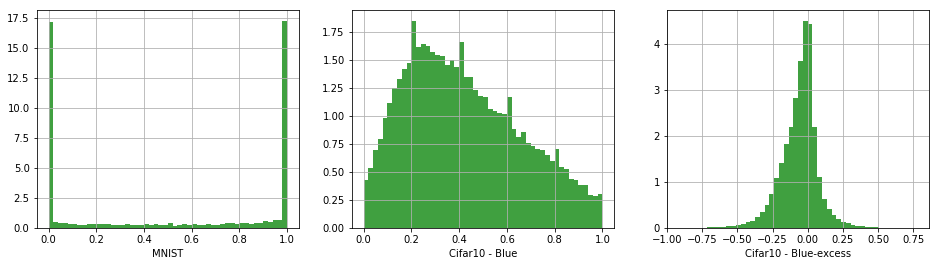

In [4]:
fig = plt.figure(figsize=(16,4))

def show(ax, d, title):
    ax.set_xlabel(title)
    z = plt.hist(d, 50, normed=1, facecolor='green', alpha=.75)
    ax.grid(True)

ax = fig.add_subplot(131)
show(ax, in1, 'MNIST')

ax = fig.add_subplot(132)
show(ax, in2, 'Cifar10 - Blue')

ax = fig.add_subplot(133)
show(ax, in3, 'Cifar10 - Blue-excess')

plt.show()

### Our non-linear function

For a given channel, we just approximate the cumulative distribution with an n-knot step function, giving a monotonic output with n+1 plateaus.

Our final function is just: f(pixel-value) = [ pixel-value > t for t in knots ]
    
Given the output is an n-hot vector of bits, the information content is just log2(knots+1). 

For small n, e.g. 6, we will reduce our channel size to under 3 bits/pixel-value. The benefit the next layer can construct limited piece-wise linear functions rather than just linear functions.

But will the non-linearity be enough to offset the information compression in terms of final accuracy?


In [5]:
class Pieces(object):
    
    def __init__(self, d, n=5):
        sz = len(d) // n
        self.d = d
        self.idx =  np.array([ i*sz for i in range(n)] + [len(d)])
        
    def idx1(self):
        idx1 = np.array(self.idx)
        idx1[-1] -= 1
        return idx1
    
    def ranges(self):
        idx = self.idx
        return list(zip(idx, idx[1:]))
    
    def mids(self):
        return [ (a+b)//2 for a,b in self.ranges() ] 
    
    def threshholds(self):
        return self.d[self.idx[1:-1]]
        
    def estimate(self, d):
        approx = np.ones_like(d) * 100
        for m, (a,b) in zip(self.values(), self.ranges()):
            approx[a:b] = m    
        return approx
    
    def err0(self):
        resid = self.d - self.estimate(self.d)
        return np.mean(np.abs(resid))
    
    def err1(self):
        resid = self.d - self.estimate(self.d)
        return np.std(resid)

    def err(self):
        return self.err1()
    
    def xLens(self):
        return np.array([ b-a for a,b in self.ranges() ] )
    
    def yLens(self):
        d = self.d
        return [ d[b-1]-d[a] for a,b in self.ranges() ]
    
    def areas(self):
        return [ a*b for a,b in zip(self.xLens(), self.yLens())]
        
    def improve(self):
        idx = self.idx
        areas = self.areas()
        
        slews0 = np.array([ b/(a+b+1e-6) for a,b in zip(areas, areas[1:])]) 
        slews = slews0 * 2 - 1
        
        targets = np.array([ i+(s>0)*2 for i,s in enumerate(slews) ])
        add = np.zeros_like(idx)
        for i, (mv, tgt) in enumerate(zip(slews, targets)):
            sp = np.abs(idx[tgt] - idx[i+1])
            n = sp * mv / 10
            add[i+1] += int(n)

        self.idx += add
        
class MedianPieces(Pieces):
    
    def values(self):
        mids = self.mids()
        return self.d[mids]
    
    def err(self):
        return self.err0()
    
class MeanPieces(Pieces):
    
    def __init__(self, d, n=5):
        super(MeanPieces, self).__init__(d, n=n)
        self.cs = np.cumsum(d)
    
    def values(self):
        cs = self.cs
        means = [ (cs[b-1]-cs[a])/(b-a) for a,b in self.ranges() ]
        return means

#### Testing initial knot guesses:

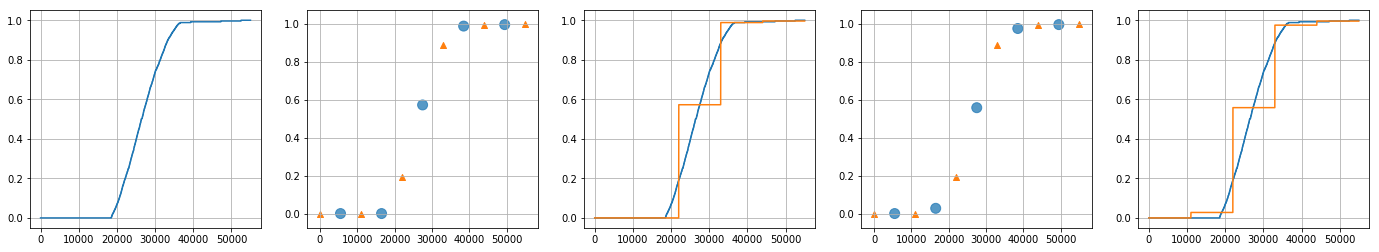

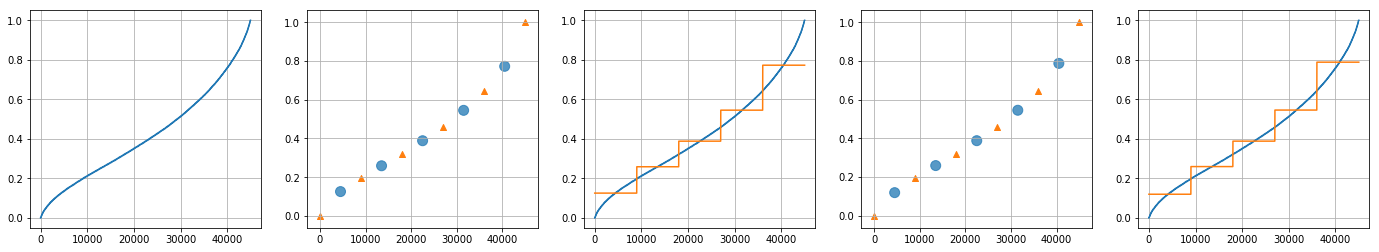

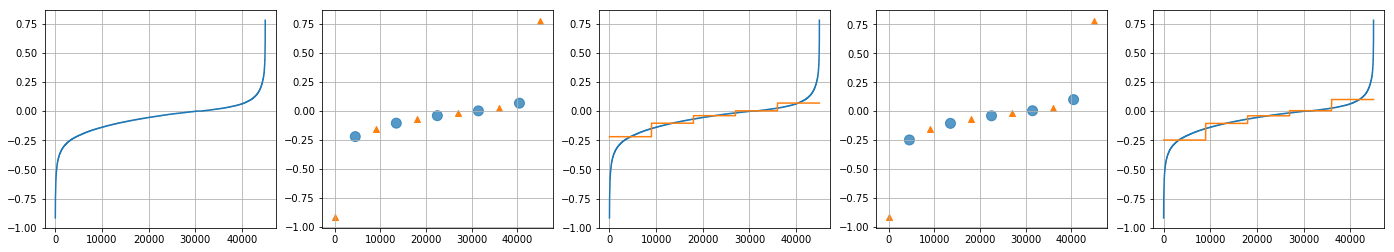

In [6]:
class PosStepFn(object):
    
    def __init__(self, x, n=5):
        d = x[:]
        self.d = np.sort(d)
        self.n = n

    def summary(self):
        
        d = self.d
        n = self.n
        
        fig = plt.figure(figsize=(24,4))

        fs = 150
        
        ax = fig.add_subplot(fs+1)
        ax.grid(True)

        plt.plot(d)

        def plotA(p, sp=1):

            v      = p.values()
            mids   = p.mids()
            ranges = p.ranges()
            idx1   = p.idx1()
            
            ax = fig.add_subplot(fs+sp)
            ax.grid(True)
            plt.scatter(mids, v, marker='o', s=[100]*len(mids), alpha=.75)
            plt.scatter(idx1,d[idx1], marker='^')

            ax = fig.add_subplot(fs+sp+1)
            ax.grid(True)
            
            plt.plot(d)
            
            approx = p.estimate(d)
            plt.plot(approx)

        median = MedianPieces(d, n=n)
        plotA(median, sp=2)
        
        mean = MeanPieces(d, n=n)
        plotA(mean, sp=4)

        plt.show()
    
PosStepFn(in1).summary()
PosStepFn(in2).summary()
PosStepFn(in3).summary()

#### Mean or median error?

I guess mean looks better.

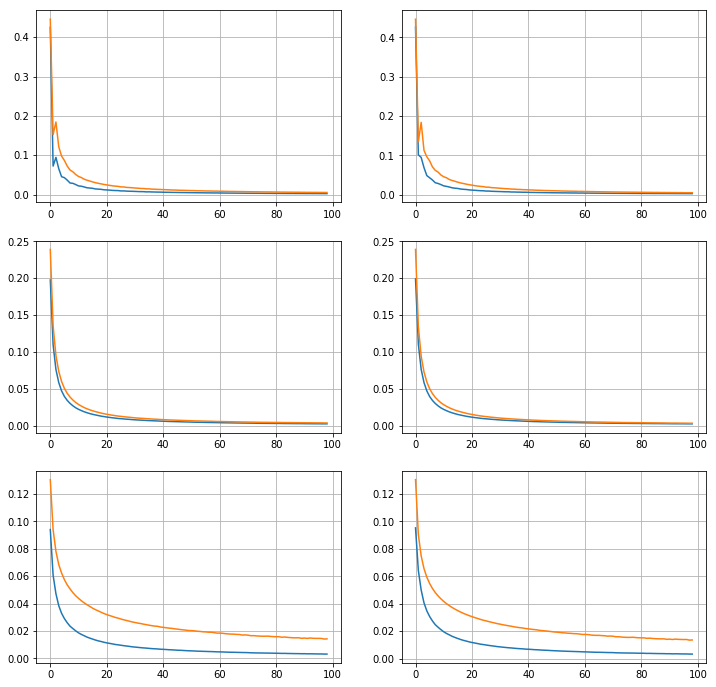

In [7]:
sp = 0
fig = plt.figure(figsize=(12,12))
for d in (in1, in2, in3):
    for c in (MedianPieces, MeanPieces):
        sp += 1
        ax = fig.add_subplot(320+sp)
        ax.grid(True)
        err = []
        for i in range(1,100):
            p = PosStepFn(d, n=i)
            mp = c(p.d, n=p.n)
            err.append((mp.err0(), mp.err1()))
        plt.plot(err)

plt.show()

#### Check the undersupervised learning of threshholds works

In [8]:
def opt(ds):
    models = [ PosStepFn(ds, n=n) for n in (2, 3, 5, 8, 13) ]
    pieces = [ MeanPieces(m.d, n=m.n)  for m in models ]
    for p in pieces:
        fig = plt.figure(figsize=(16,2))
        errs = []
        for i in range(5):
            ax = fig.add_subplot(161+i)
            ax.grid(True)
            ax.axes.get_xaxis().set_visible(False)

            plt.plot(p.d)

            approx = p.estimate(p.d)
            plt.plot(approx)

            for j in range(20):
                errs.append(p.err())
                p.improve()

        ax = fig.add_subplot(166)
        ax.grid(True)
        plt.plot(errs)
        plt.tight_layout()

        plt.show()

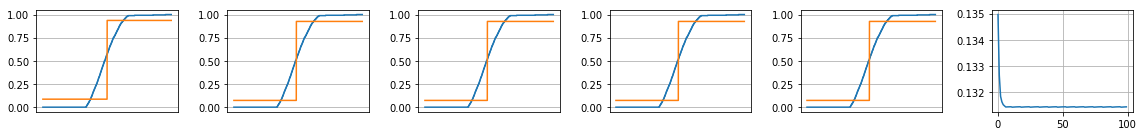

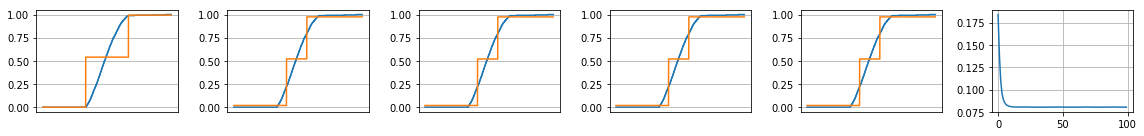

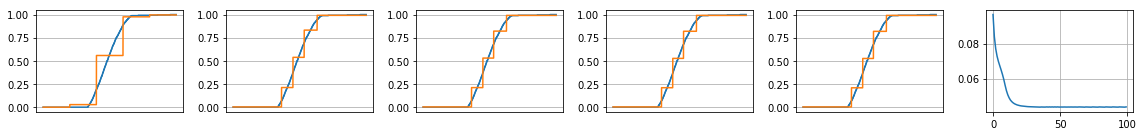

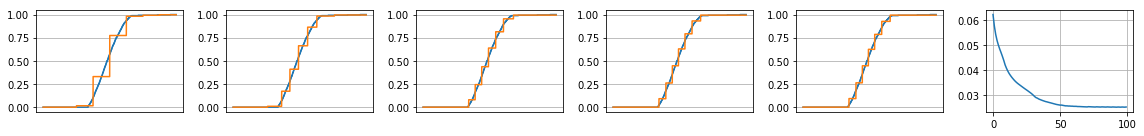

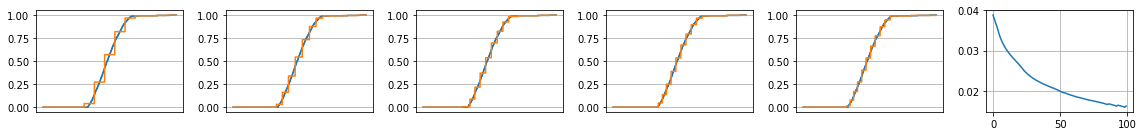

In [9]:
opt(in1)

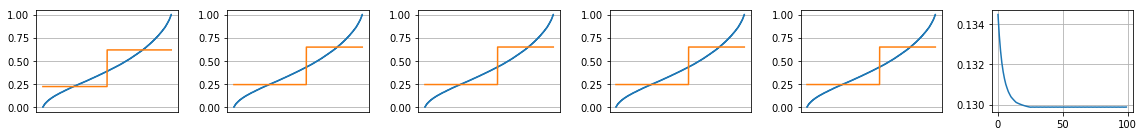

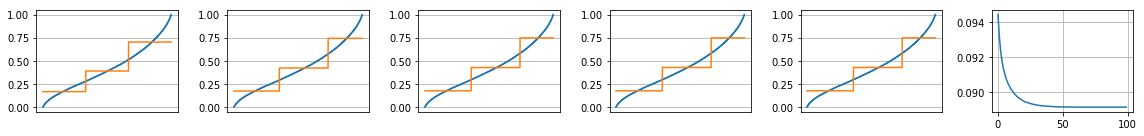

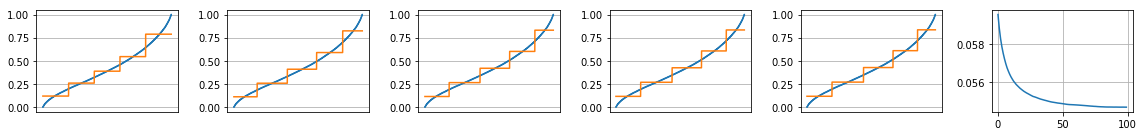

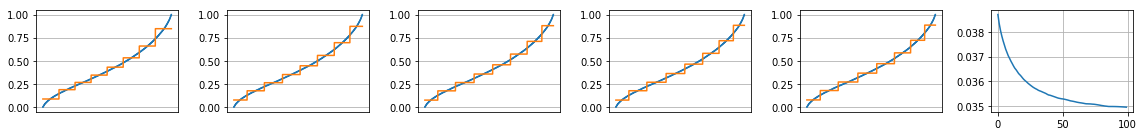

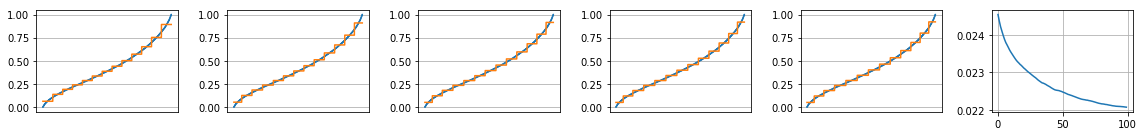

In [10]:
opt(in2)

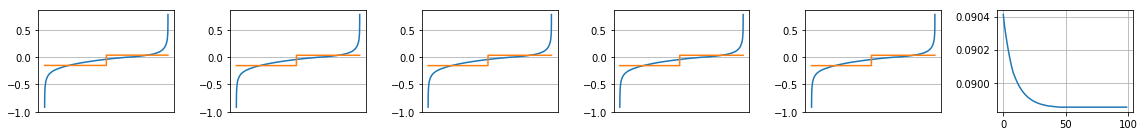

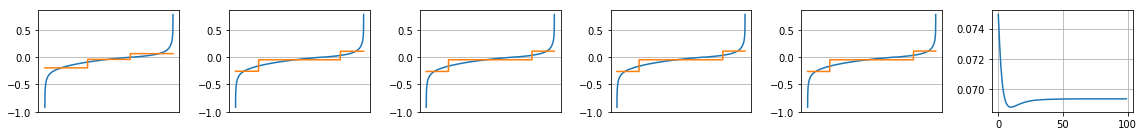

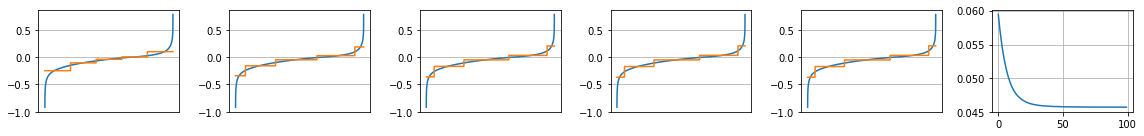

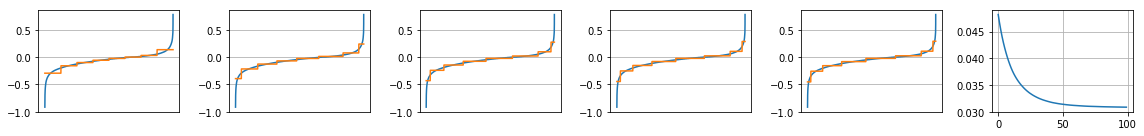

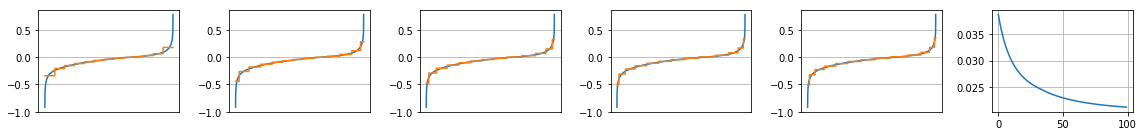

In [11]:
opt(in3)

### Compute threshholds for MNIST

In [12]:
n = 6
w = []
for a in range(28):
    for b in range(28):
        inp = ds1[:, a, b, 0]
        m = PosStepFn(inp, n=n)
        p = MeanPieces(m.d, n=m.n)
        for j in range(100):
            p.improve()
        w.append(p.threshholds())
w = np.array(w)

print(w[14*28+14])
print(w.shape)

[ 0.04313726  0.27450982  0.52549022  0.76470596  0.95686281]
(784, 5)


### Finally, train a fully-connected readout layer:


0: 0.12 0.95 0.91 0.95 0.88 0.92 0.93 0.89 0.88 0.9 
1000: 0.95 0.92 0.96 0.95 0.95 0.95 0.92 0.93 0.93 0.91 
2000: 0.93 0.96 0.92 0.95 0.91 0.91 0.94 0.93 0.94 0.91 
3000: 0.96 0.92 0.91 0.93 0.94 0.91 0.92 0.94 0.86 0.93 
4000: 0.91 0.95 0.95 0.92 0.96 0.94 0.9 0.95 0.93 0.96 
5000: 0.94 0.92 0.96 0.92 0.93 0.93 0.92 0.97 0.96 0.95 
6000: 0.97 0.93 0.92 0.95 0.93 0.93 0.9 0.93 0.94 0.97 
7000: 0.91 0.96 0.95 0.97 0.97 0.91 0.96 0.91 0.96 0.97 
8000: 0.96 0.95 0.96 0.96 0.96 0.95 0.98 0.97 0.98 0.94 
9000: 0.94 0.97 0.97 0.9 0.95 0.92 0.92 0.95 0.95 0.94 
10000: 0.96 
0.9328


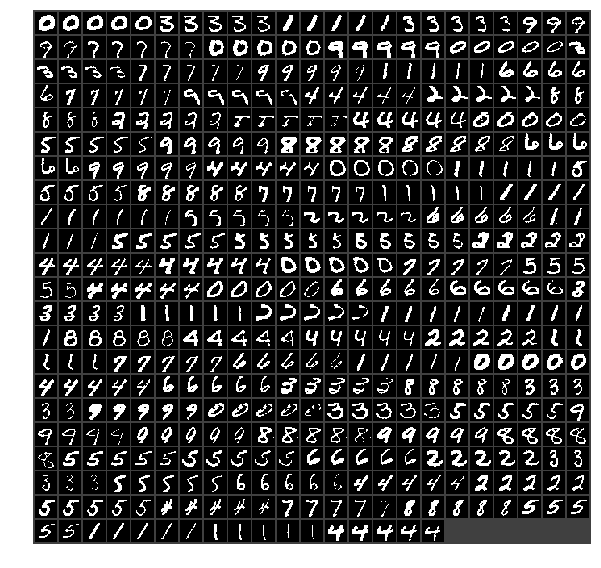

In [13]:
from ml.utils import show

nc = n-1

x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784*nc, 10]))

b = tf.Variable(tf.zeros([10]))

z = tf.reshape(x, (-1, 784, 1))
bits = z > w # ?, 784, 5
bits = tf.cast(bits, tf.float32)

bits = tf.reshape(bits, (-1, 784*nc))


y = tf.nn.softmax(tf.matmul(bits, W) + b)

y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for i in range(10001):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    a, _ = sess.run((accuracy,train_step), feed_dict={x: batch_xs, y_: batch_ys})
    if i % 1000 == 0:
        print()
        print('%s: ' % i, end='')
    if i % 100 == 0:
        print(a,  end=' ')
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print()
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

v = sess.run(bits, feed_dict={x: batch_xs, y_: batch_ys})
v = v.reshape(100, 28, 28, nc)
v = v.transpose((0,3,1,2))
v = v.reshape(100*nc,28,28,1)
show(v)